# Overview

Before building the base GRN, we need to annotate the coaccessible peaks and filter our active promoter/enhancer elements. First, we will identify the peaks around transcription starting sites (TSS). We will then merge the Cicero data with the TSS peak information and filter any peaks with weak connections to the TSS peaks. As such, the filtered peak data will only include TSS peaks and peaks with strong TSS connections. These will be our active promoter/enhancer elements for our base GRN. 

### Notebook file

Notebook file is available on CellOracle GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/02_preprocess_peak_data.ipynb



# 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [2]:
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [35]:
# %config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
%matplotlib inline

In [34]:
# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
#     plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
set_plotting_style()

In [5]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/peaks_TDR118"
os.makedirs(figpath, exist_ok=True)

# 1. Load scATAC peak data and peak connection data made with Cicero

## 1.0. Download data

In this notebook, we will annotate and filter output from Cicero. Please refer to the previous step to learn about data preparation with Cicero.
https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html#step1-scatac-seq-analysis-with-cicero


Here, we will use the preprocessed fetal brain scATAC-seq data from step 1.


You can download the demo file by running the following command. 

Note: If the download fails, please manually download and unzip the data.
https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv

https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv

In [4]:
# # Download file. 
# !wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
# !wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv
    
# # If you are using macOS, please try the following command.
# #!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
# #!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv


--2023-01-20 17:19:21--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940392 (2.8M) [text/plain]
Saving to: ‘all_peaks.csv’

all_peaks.csv       100%[===================>]   2.80M  --.-KB/s    in 0.03s   

2023-01-20 17:19:22 (92.3 MB/s) - ‘all_peaks.csv’ saved [2940392/2940392]

--2023-01-20 17:19:22--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 

## 1.1. Load data

In [10]:
cicero_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/"

In [11]:
# Load scATAC-seq peak list.
peaks = pd.read_csv(cicero_output_path+"01_TDR118_CRG_arc_peaks.csv", index_col=0)
peaks = peaks.x.values
peaks

array(['1-2372-3057', '1-6507-7253', '1-11485-12198', ...,
       '9-56450898-56451686', '9-56452315-56452858',
       '9-56459068-56459827'], dtype=object)

In [12]:
len(peaks)

248320

In [13]:
# add "chr" in front of each peak element for formatting (CellOracle genome reference)
peaks = "chr" + peaks
peaks

# reformat the peaks (replace the "-" with "_")
peaks = [s.replace("-","_") for s in peaks]
peaks = np.array(peaks)
peaks

array(['chr1_2372_3057', 'chr1_6507_7253', 'chr1_11485_12198', ...,
       'chr9_56450898_56451686', 'chr9_56452315_56452858',
       'chr9_56459068_56459827'], dtype='<U23')

In [14]:
# Load Cicero coaccessibility scores.
cicero_connections = pd.read_csv(cicero_output_path + "02_TDR118_cicero_connections_CRG_arc_peaks.csv", index_col=0)
cicero_connections.head()

,Peak1,Peak2,coaccess
1,1-10000089-10000951,1-9799170-9799935,-0.073049
2,1-10000089-10000951,1-9820778-9821643,-0.069486
3,1-10000089-10000951,1-9846358-9847274,-0.040536
4,1-10000089-10000951,1-9858069-9858966,-0.028729
5,1-10000089-10000951,1-9859992-9860913,-0.025691


In [15]:
len(cicero_connections)

39776378

In [ ]:
# cicero_connections.coaccess.hist(bins=30)
plt.hist(cicero_connections["coaccess"], bins=50)
plt.yscale("log")
plt.xlabel("co-accessibility score")
plt.ylabel("occurences")
plt.savefig(figpath+"/cicero_scores_histogram.pdf")

In [17]:
cicero_connections[cicero_connections["coaccess"]<-0.6].sort_values("coaccess")

,Peak1,Peak2,coaccess
25081532,24-17168001-17168928,24-17160375-17161077,-0.673312
25080832,24-17160375-17161077,24-17168001-17168928,-0.673312
24130795,23-32499634-32500463,23-32198630-32199562,-0.665333
24115462,23-32198630-32199562,23-32499634-32500463,-0.665333
11553317,16-33655530-33656446,16-33484518-33485430,-0.658803
...,...,...,...
1966764,10-27126669-27127580,10-27203983-27204783,-0.602423
12115900,16-51407153-51407994,16-51141595-51142506,-0.602304
12102462,16-51141595-51142506,16-51407153-51407994,-0.602304
25080843,24-17160375-17161077,24-17194853-17195761,-0.600365


In [ ]:
cicero_connections.head()

In [16]:
# add "chr" in front of each peak element for formatting (CellOracle genome reference)
cicero_connections["Peak1"] = "chr" + cicero_connections["Peak1"]
cicero_connections["Peak2"] = "chr" + cicero_connections["Peak2"]

# replace the "-" with "_"
cicero_connections["Peak1"] = [s.replace("-","_") for s in cicero_connections["Peak1"]]
cicero_connections["Peak2"] = [s.replace("-","_") for s in cicero_connections["Peak2"]]

cicero_connections.head()

,Peak1,Peak2,coaccess
1,chr1_10000089_10000951,chr1_9799170_9799935,-0.073049
2,chr1_10000089_10000951,chr1_9820778_9821643,-0.069486
3,chr1_10000089_10000951,chr1_9846358_9847274,-0.040536
4,chr1_10000089_10000951,chr1_9858069_9858966,-0.028729
5,chr1_10000089_10000951,chr1_9859992_9860913,-0.025691


In [17]:
cicero_connections.tail()

,Peak1,Peak2,coaccess
40024380,chr9_9997566_9998393,chr9_10218935_10219764,0.000132
40024381,chr9_9997566_9998393,chr9_10220226_10221127,0.001715
40024382,chr9_9997566_9998393,chr9_10223977_10224768,0.000078
40024383,chr9_9997566_9998393,chr9_10234336_10235271,0.007772
40024384,chr9_9997566_9998393,chr9_10235921_10236844,0.000000


In [24]:
# Just to check if there are peaks from chromosomes 10 (or above)
cicero_connections[cicero_connections.Peak1.str.startswith("MT")]

,Peak1,Peak2,coaccess


In [23]:
np.arange(1,26)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [18]:
# make an empty list 
n_peaks_chrom = []

for chromosome in np.arange(1,26):
    chrom_num = chromosome
    chrom_id = "chr"+str(chrom_num)
    n_peaks = len(cicero_connections[cicero_connections.Peak1.str.startswith(chrom_id)])
    n_peaks_chrom.append(n_peaks)

n_peaks_chrom


[17313404,
 9804346,
 1642932,
 1448972,
 2082936,
 1767088,
 2360162,
 1521416,
 1835122,
 1367330,
 1565672,
 1380020,
 1923188,
 1468194,
 1491042,
 1711088,
 1598742,
 1628318,
 1685318,
 1611028,
 1344260,
 1116190,
 1756094,
 1342086,
 1072050]

In [22]:
data = [
    1, 59578282, 2, 59640629, 3, 62628489, 4, 78093715, 5, 72500376, 
    6, 60270059, 7, 74282399, 8, 54304671, 9, 56459846, 10, 45420867, 
    11, 45484837, 12, 49182954, 13, 52186027, 14, 52660232, 15, 48040578, 
    16, 55266484, 17, 53461100, 18, 51023478, 19, 48449771, 20, 55201332, 
    21, 45934066, 22, 39133080, 23, 46223584, 24, 42172926, 25, 37502051, 
    "MT", 16596
]

# Extract even-positioned numbers
even_numbers = data[1::2]

# Create a list of indices ranging from 1 to "MT"
indices = [str(i) for i in range(1, len(even_numbers) + 1)]

# Create a DataFrame
df_chrom_length = pd.DataFrame({'chr': indices, 'Length': even_numbers})

print(df_chrom_length)

   chr    Length
0    1  59578282
1    2  59640629
2    3  62628489
3    4  78093715
4    5  72500376
5    6  60270059
6    7  74282399
7    8  54304671
8    9  56459846
9   10  45420867
10  11  45484837
11  12  49182954
12  13  52186027
13  14  52660232
14  15  48040578
15  16  55266484
16  17  53461100
17  18  51023478
18  19  48449771
19  20  55201332
20  21  45934066
21  22  39133080
22  23  46223584
23  24  42172926
24  25  37502051
25  26     16596


In [26]:
zip(n_peaks_chrom, df_chrom_length["Length"][0:25])

In [28]:
n_peaks_chrom
df_chrom_length["Length"][0:25]

n_peaks_chrom_normalized_by_length = [x/y for x,y in zip(n_peaks_chrom, df_chrom_length["Length"][0:25])]
n_peaks_chrom_normalized_by_length

[0.29059924890079913,
 0.16439038562118452,
 0.026232981606821137,
 0.01855427162096207,
 0.028730002724399663,
 0.029319500085440434,
 0.0317728295231822,
 0.028016300844544293,
 0.03250313505991497,
 0.030103564513640834,
 0.03442184480071897,
 0.028058908377077148,
 0.03685254675547537,
 0.02788050762860293,
 0.03103713698032526,
 0.030960681341697077,
 0.029904771880862907,
 0.03191311262630901,
 0.03478484965388175,
 0.029184585618332544,
 0.029264990388614846,
 0.028522927405662934,
 0.03799129898711446,
 0.03182340253080851,
 0.02858643651249901]

In [32]:
n_peaks_chrom_normalized_by_length = [x/n_peaks_chrom_normalized_by_length[0] for x in n_peaks_chrom_normalized_by_length]
n_peaks_chrom_normalized_by_length

[1.0,
 0.5656944615066845,
 0.09027202136980127,
 0.06384831237914135,
 0.09886468335025575,
 0.10089324110899245,
 0.10933555280464054,
 0.09640871733329263,
 0.11184865474655943,
 0.10359133627326471,
 0.11845125178719727,
 0.09655533688820896,
 0.12681569857758165,
 0.09594143045469605,
 0.10680391328513136,
 0.10654081680805039,
 0.10290725799869976,
 0.10981829012642452,
 0.11970041142727156,
 0.10042897815023323,
 0.10070566424142732,
 0.09815210298564711,
 0.13073433304049392,
 0.10950958287463418,
 0.09837064830906518]

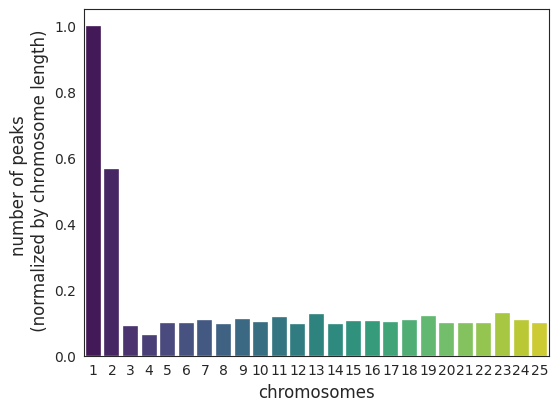

In [36]:
sns.barplot(x=list(np.arange(1,26)), y=n_peaks_chrom_normalized_by_length, palette = "viridis")
plt.xlabel("chromosomes")
plt.ylabel("number of peaks \n (normalized by chromosome length)")
plt.savefig(figpath+"/n_CCANs_per_chromosome_norm_scaled.pdf")

Text(0, 0.5, 'number of peaks')

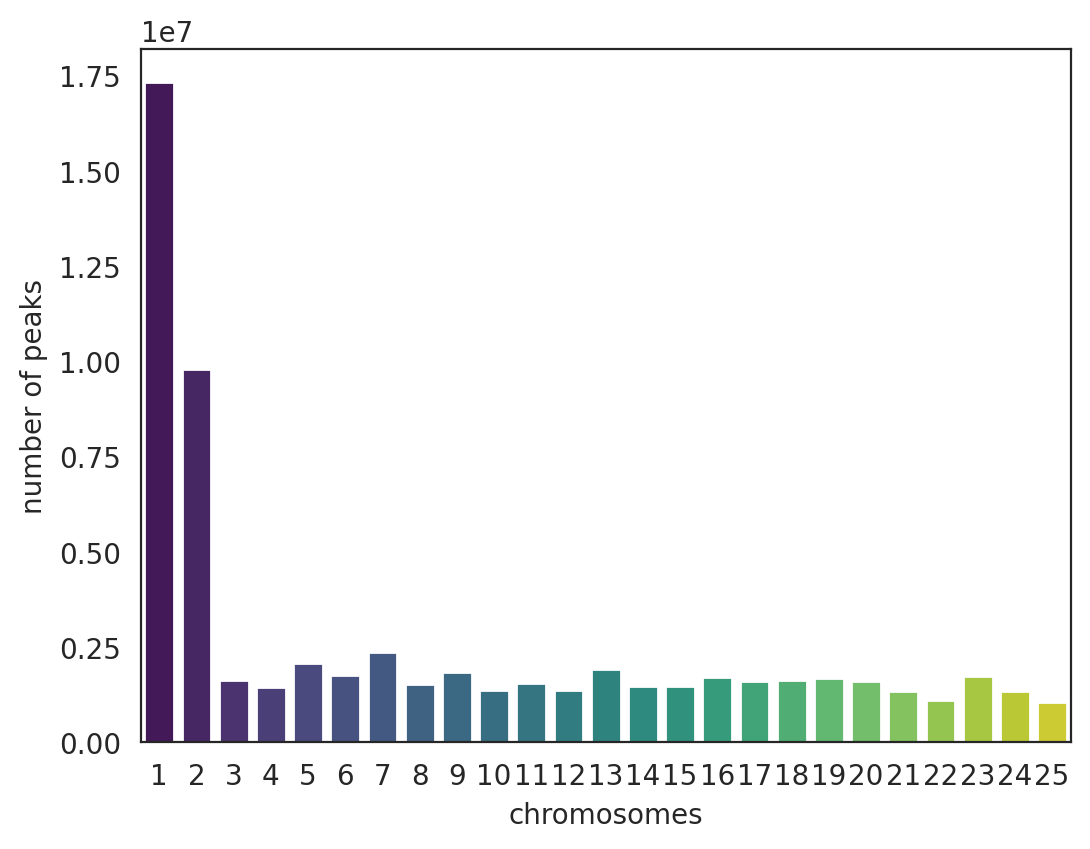

In [36]:
sns.barplot(x=list(np.arange(1,26)), y=n_peaks_chrom, palette = "viridis")
plt.xlabel("chromosomes")
plt.ylabel("number of peaks")
plt.savefig(figpath+"/n_CCANs_per_chromosome.pdf")

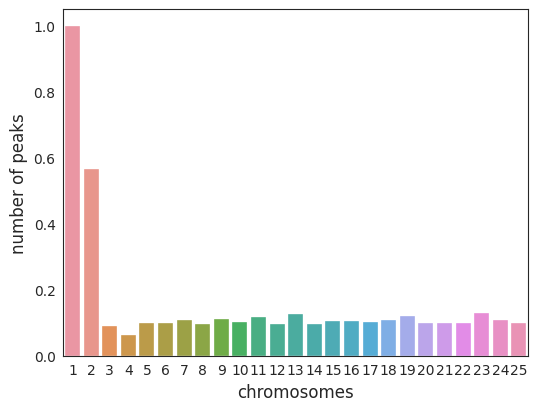

In [38]:
sns.barplot(x=list(np.arange(1,26)), y=n_peaks_chrom_normalized_by_length)
plt.xlabel("chromosomes")
plt.ylabel("number of peaks")
plt.savefig(figpath+"/n_CCANs_per_chromosome_norm_scaled_R_palette.pdf")

Text(0, 0.5, 'number of peaks')

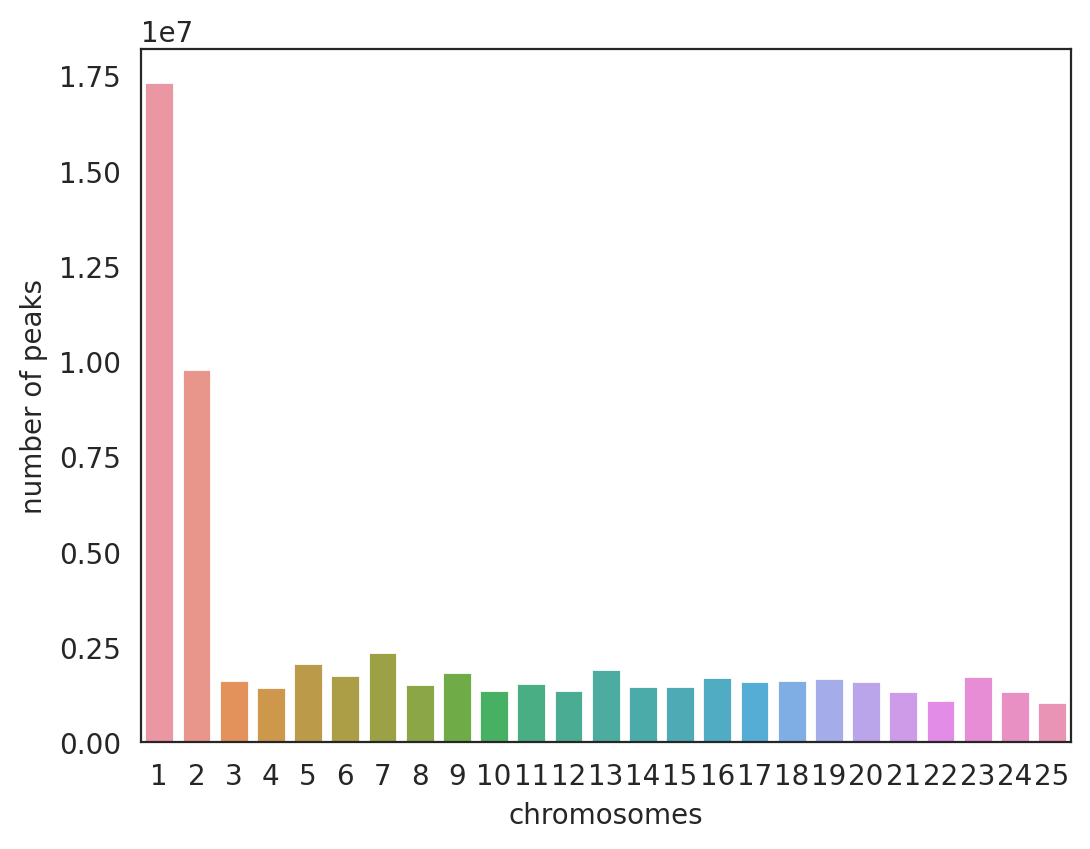

In [37]:
sns.barplot(x=list(np.arange(1,26)), y=n_peaks_chrom)
plt.xlabel("chromosomes")
plt.ylabel("number of peaks")
plt.savefig(figpath+"/n_CCANs_per_chromosome.pdf")


# 2. Annotate transcription start sites (TSSs)¶
## IMPORTANT: Please make sure that you are setting correct reference genoms.
 If your scATAC-seq data was generated with danRer11 reference genome, please set `ref_genome="danRer11"`.
 
You can check supported reference genome using `ma.SUPPORTED_REF_GENOME`

 If your reference genome is not in the list, please send a request to us through CellOracle GitHub issue page.

In [39]:
ma.SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


In [7]:
# # bedtools has to be re-installed
# conda install -c bioconda bedtools

## Check - TSS annotation from the reference genome

- Note that we can also generate our own custom TSS annotation (check the Lawson lab's latest anotation)

In [81]:
def _load_tss_ref_data(ref_genome):

    """
    Args:
        ref_genome (str): Reference genome name.
            Please contact us through github issue page if you have a request for another referene genome.
    """
    path = os.path.join(parent_path[0], "tss_ref_data", f"{ref_genome}_tss_info.bed")
    return BedTool(fn=path)

In [53]:
from celloracle.motif_analysis import __path__ as parent_path
from pybedtools import BedTool

In [63]:
from celloracle.motif_analysis.reference_genomes import SUPPORTED_REF_GENOME
SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


In [68]:
ref_genome = _load_tss_ref_data(ref_genome = "danRer11")
ref_genome

<BedTool(/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/motif_analysis/tss_ref_data/danRer11_tss_info.bed)>

In [83]:
df_zebrafish_ref_genome = ref_genome.to_dataframe()
df_zebrafish_ref_genome

,chrom,start,end,name,score,strand
0,chr18,48530121,48531221,kcnj1a.2,-450,-
1,chr10,34033347,34034447,rfc3,-450,-
2,chr16,22864944,22866044,flad1,-450,+
3,chr12,46739584,46740684,plaub,-450,+
4,chr12,41697174,41698274,bnip3,-450,+
...,...,...,...,...,...,...
17795,chr5,38096024,38097124,si:ch211-284e13.5,-450,+
17796,chr5,70344518,70345618,pappaa,-450,+
17797,chr21_KZ115628v1_alt,57121,57857,nectin1a,469,+
17798,chr13,31377201,31378301,ubtd1a,-450,-


In [75]:
"meox1" in ref_genome.to_dataframe().name

False

In [40]:
##!! Please make sure to specify the correct reference genome here
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="danRer11") 

# Check results
tss_annotated.tail()

que bed peaks: 248320
tss peaks in que: 14372


,chr,start,end,gene_short_name,strand
14367,chr5,38096894,38097792,si:ch211-284e13.5,+
14368,chr5,70345049,70345786,pappaa,+
14369,chr13,31376751,31377551,ubtd1a,-
14370,chr13,31378197,31379115,ubtd1a,-
14371,chr6,42289578,42290470,tex264a,-


In [ ]:
ma.get_tss_info()

In [47]:
"myog" in tss_annotated.gene_short_name

False

# 3. Integrate TSS info and cicero connections

The output file after the integration process has three columns: `["peak_id", "gene_short_name", "coaccess"`].

- "peak_id" is either the TSS peak or the peaks that have a connection to a TSS peak.
- "gene_short_name" is the gene name that associated with the TSS site. 
- "coaccess" is the coaccessibility score between the peak and a TSS peak. If the score is 1, it means that the peak is a TSS itself.


**Question: Check if the CCANs with negative cicero scores are filtered out at this step.**

**ANSWER**: It does filter out the CCANs with negative cicero scores, and also assign "1" for the same peak-TSS combo (for the TSS-TSS pairs)

In [39]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)
print(integrated.shape)
integrated.head()

(1056808, 3)


,peak_id,gene_short_name,coaccess
0,chr10_10001645_10002381,mir219-1,0.035199
1,chr10_10001645_10002381,urm1,0.010262
2,chr10_10003590_10004266,urm1,0.012672
3,chr10_10004570_10005459,mir219-1,0.475773
4,chr10_10004570_10005459,urm1,0.005687


# 4. Filter peaks
Remove peaks with weak coaccessibility scores.

- Note that, from here, co-accessibility score >=0.8, we will just connect those peaks to the TSS/gene_names, and will ignore the co-accessbility scores from now on.

Text(0, 0.5, 'occurences')

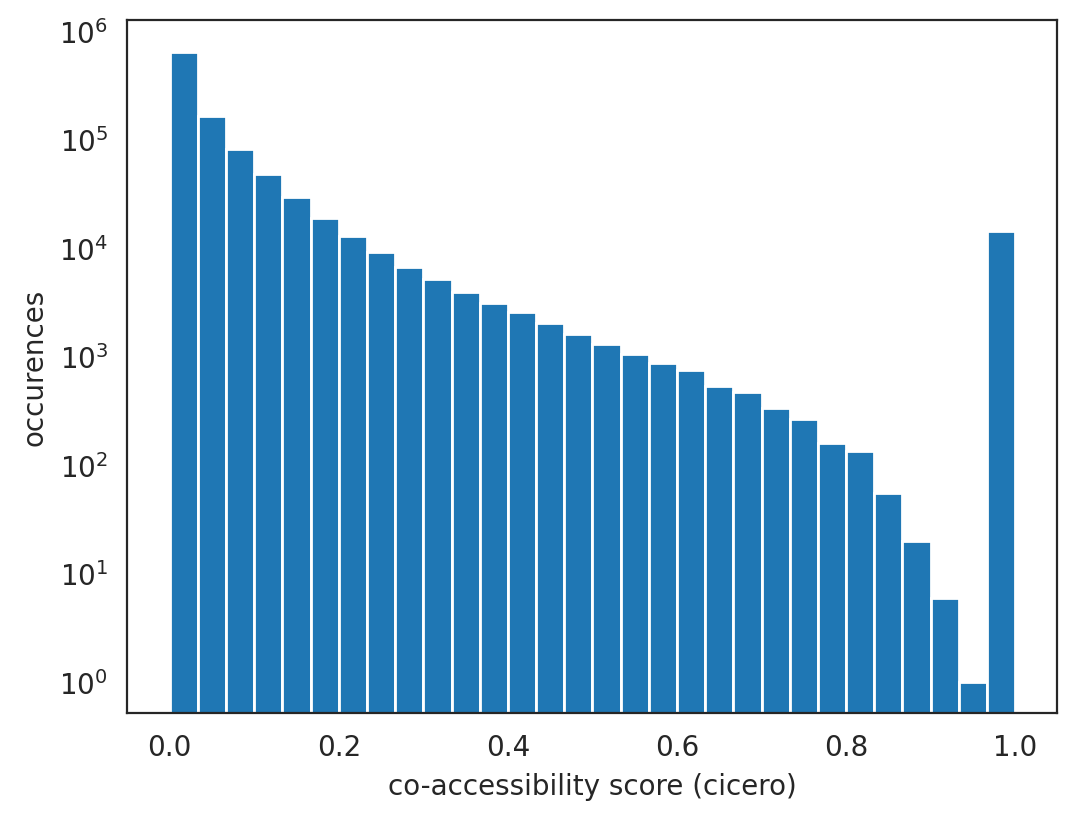

In [20]:
# (optional) plot a histogram to see the distribution of the co-accessibility scores
%matplotlib inline
plt.hist(integrated["coaccess"], bins=30)
plt.yscale("log")
plt.xlabel("co-accessibility score (cicero)")
plt.ylabel("occurences")

Question - does the ma.integrate_tss_peak_with_cicero filter out the peaks with co-accessiblity score <0?

In [21]:
peak = integrated[integrated.coaccess >= 0.8]
peak = peak[["peak_id", "gene_short_name"]].reset_index(drop=True)
peak

,peak_id,gene_short_name
0,chr10_10310135_10311044,mir219-1
1,chr10_10312654_10313520,urm1
2,chr10_10318857_10319768,mir219-1
3,chr10_10330150_10331040,mir219-1
4,chr10_10728430_10729439,swi5
...,...,...
14506,chr9_9670995_9671898,gsk3ba
14507,chr9_9841650_9842440,fstl1b
14508,chr9_9960217_9961167,prmt2
14509,chr9_9977190_9977958,ugt1a1


In [22]:
print(peak.shape)
peak.head()

(14511, 2)


,peak_id,gene_short_name
0,chr10_10310135_10311044,mir219-1
1,chr10_10312654_10313520,urm1
2,chr10_10318857_10319768,mir219-1
3,chr10_10330150_10331040,mir219-1
4,chr10_10728430_10729439,swi5


# 5. Save data
Save the promoter/enhancer peaks.

In [24]:
peak.to_csv(cicero_output_path+ "processed_peak_file_danRer11.csv")

**Please go to next step: Transcriptoin factor motif scan**

https://morris-lab.github.io/CellOracle.documentation/tutorials/motifscan.html